In [1]:
%matplotlib notebook
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import griddata
import h5py
plt.style.use('classic')
plt.rcParams['font.serif']=['Computer Modern Roman']
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12
plt.rcParams['font.size']=12


In [2]:
class sim_avg:
    def __init__(self,csv_filename,save_directory):
        self.csv_filename=csv_filename
        self.save_directory=save_directory

    def csv_slice_to_npy(self):
        # read in data
        #d=np.genfromtxt('../Data/data_slice_000_z.csv',delimiter=',',skip_header=1)
        d=np.genfromtxt(self.csv_filename,delimiter=',',skip_header=1)
        uexp,u,v,w,uavg,vavg,wavg,urms,vrms,wrms,x,y,z=[ d[:,i] for i in range(0,13) ]

        # non-dimensionalize everything
        D_ref = 0.00745
        U_ref = 27.5
        x = x/D_ref
        y = y/D_ref
        z = z/D_ref
        uexp=uexp/U_ref
        u=u/U_ref
        v=v/U_ref
        w=w/U_ref
        uavg=uavg/U_ref
        vavg=vavg/U_ref
        wavg=wavg/U_ref
        urms=urms/U_ref
        vrms=vrms/U_ref
        wrms=wrms/U_ref

        # interpolate to grid
        nx=3000j
        ny=260j
        #self.Xall,self.Yall=np.mgrid[0:17:nx,-3:3:ny] # make grid of slice down the middle (if more data is given, can do slice of whole domain to get the whole experimental region)
        self.Xall,self.Yall=np.mgrid[0:30:nx,-4:4:ny] # make grid of slice down the middle (if more data is given, can do slice of whole domain to get the whole experimental region)
        self.XCL,self.YCL=np.mgrid[0:30:nx,0:1:1j] # make grid of slice down the middle (if more data is given, can do slice of whole domain to get the whole experimental region)
        points=np.array([x,y]).T
        self.Uexp=griddata(points,uexp,(self.Xall,self.Yall),method='linear')
        self.Urms=griddata(points,urms,(self.Xall,self.Yall),method='linear')
        self.Uavg=griddata(points,uavg,(self.Xall,self.Yall),method='linear')
        self.Vavg=griddata(points,vavg,(self.Xall,self.Yall),method='linear')
        self.UCL=griddata(points,uavg,(self.XCL,self.YCL),method='linear')
        self.VCL=griddata(points,vavg,(self.XCL,self.YCL),method='linear')

        # save interpolated data
        np.save(self.save_directory+'/uexp',self.Uexp)
        np.save(self.save_directory+'/uavg',self.Uavg)
        np.save(self.save_directory+'/vavg',self.Vavg)
        np.save(self.save_directory+'/urms',self.Urms)
        np.save(self.save_directory+'/ucl',self.UCL)
        np.save(self.save_directory+'/vcl',self.VCL)
        np.save(self.save_directory+'/X',self.Xall)
        np.save(self.save_directory+'/Y',self.Yall)
        np.save(self.save_directory+'/Xcl',self.XCL)
        np.save(self.save_directory+'/Ycl',self.YCL)

    def load(self):
        # load data
        self.Uavg=np.load(self.save_directory+'/uavg.npy')
        self.Vavg=np.load(self.save_directory+'/vavg.npy')
        self.Urms=np.load(self.save_directory+'/urms.npy')
        self.Uexp=np.load(self.save_directory+'/uexp.npy')
        self.UCL =np.load(self.save_directory+'/ucl.npy')
        self.VCL =np.load(self.save_directory+'/vcl.npy')
        self.Xall=np.load(self.save_directory+'/X.npy')
        self.Yall=np.load(self.save_directory+'/Y.npy')
        self.XCL=np.load(self.save_directory+'/Xcl.npy')
        self.YCL=np.load(self.save_directory+'/Ycl.npy')
        # change exp data to nan and 1000
        temp=self.Uexp.copy()
        temp[self.Uexp==0]=np.nan
        temp[np.isfinite(temp)]=1000
        # get bounding values for exp data
        self.exp_range=np.isfinite(temp)
        self.xmin=np.min(self.Xall[self.exp_range])
        self.xmax=np.max(self.Xall[self.exp_range])
        self.ymin=np.min(self.Yall[self.exp_range])
        self.ymax=np.max(self.Yall[self.exp_range])
        self.xwidth=self.xmax-self.xmin
        self.ywidth=self.ymax-self.ymin

In [3]:
class exp_avg:
    def __init__(self,ave_u_npy,ave_v_npy,mat_filename):
        self.ave_u_npy=ave_u_npy
        self.ave_v_npy=ave_v_npy
        self.mat_filename=mat_filename
    def load(self):
        expv=np.load(self.ave_v_npy)
        expu=np.load(self.ave_u_npy)
        # read in X and Y
        f=h5py.File(mat_filename)
        expX = np.array(f['X'][0,:])
        expY = np.array(f['Y'][0,:])
        D_ref=0.00745
        U_ref=27.5
        expY=expY/(1000.)+15.*D_ref # mm to m and 15 diam. downstream
        expX=expX/1000.-(1.15*D_ref) # centered between nozzles
        # non-dimensionalize everything
        expX = expX/D_ref
        expY = expY/D_ref
        expv = expv/U_ref
        expu = expu/U_ref
        # make mesh grid for plotting
        expX,expY=np.meshgrid(expX,expY,indexing='ij')

        # save non-dimensional data to self
        self.u=expu
        self.v=expv
        self.x=expX
        self.y=expY
    def center_line(self):
        self.XCL,self.YCL=np.mgrid[0:1:1j,self.y.min():self.y.max():100j] # make grid of slice down the middle (if more data is given, can do slice of whole domain to get the whole experimental region)
        points=np.array([self.x.flatten(),self.y.flatten()]).T
        self.VCL=griddata(points,self.v.flatten(),(self.XCL,self.YCL),method='linear')
        self.UCL=griddata(points,self.u.flatten(),(self.XCL,self.YCL),method='linear')
        
        
        


In [16]:
def plot_data_u(sim,exp):
    figavg = plt.figure(figsize=(8,3))
    figexp1 = plt.figure(figsize=(4,4))
    figexp2 = plt.figure(figsize=(4,4))
    figcolorbar = plt.figure(figsize=(2,4))
    figexp3 = plt.figure(figsize=(5,3))
    # average velocity plot
    #axavg=fig.add_subplot(131)
    #axavg      =plt.subplot2grid((4,100),(0,0),rowspan=4,colspan=30)
    #axexp1     =plt.subplot2grid((4,100),(0,30),rowspan=2,colspan=30)
    #axexp2     =plt.subplot2grid((4,100),(2,30),rowspan=2,colspan=30)
    #ax_colorbar=plt.subplot2grid((4,100),(0,60),rowspan=4,colspan=15)
    #axexp3     =plt.subplot2grid((4,100),(0,75),rowspan=4,colspan=25)
    #colormap=np.linspace(np.nanmin(sim.Uavg),np.nanmax(sim.Uavg),300)
    axavg      =figavg.add_subplot(111)
    axexp1     =figexp1.add_subplot(111)
    axexp2     =figexp2.add_subplot(111)
    ax_colorbar=figcolorbar.add_subplot(111)
    axexp3     =figexp3.add_subplot(111)
    colormap=np.linspace(np.nanmin(sim.Uavg),np.nanmax(sim.Uavg),300)
    #colormap=300
    plt.colorbar(axavg.contourf(-sim.Yall,sim.Xall,sim.Uavg,colormap,cmap='jet'),ax=axavg)
    #axavg.contourf(sim.Yall,sim.Xall,sim.Uavg,colormap,cmap='jet')
    # add rectangle
    axavg.add_patch(patches.Rectangle(
        (-sim.ymin,sim.xmin),
        -sim.ywidth,
        sim.xwidth,
        fill=False,
        edgecolor='red',
        linewidth=2,
        ))
    axavg.set_xlabel(r'$Y/D$')
    axavg.set_ylabel(r'$X/D$')
    axavg.axis('scaled')

    # zoomed simulation region data
    colormap=np.linspace(np.nanmin(sim.Uavg[sim.exp_range]),np.nanmax(sim.Uavg[sim.exp_range]),300)
    #axexp1=fig.add_subplot(2,4,2)
    #plt.colorbar(axexp1.tricontourf(sim.Yall[sim.exp_range],sim.Xall[sim.exp_range],sim.Uavg[sim.exp_range],colormap,cmap='jet'),ax=axexp1)
    contour_sim=axexp1.tricontourf(-sim.Yall[sim.exp_range],sim.Xall[sim.exp_range],sim.Uavg[sim.exp_range],colormap,cmap='jet')
    axexp1.set_title('sim')
    axexp1.set_xlabel(r'$Y/D$')
    axexp1.set_ylabel(r'$X/D$')
    axexp1.axis('scaled')
    #
    #axexp2=fig.add_subplot(2,4,6)
    #plt.colorbar(axexp2.tricontourf(sim.Yall[sim.exp_range],sim.Xall[sim.exp_range],sim.Uavg[sim.exp_range],colormap,cmap='jet',),ax=axexp2)
    contour_exp=axexp2.contourf(-exp.x,exp.y,exp.v,colormap,cmap='jet',)
    axexp2.set_title('exp')
    axexp2.set_xlabel(r'$Y/D$')
    axexp2.set_ylabel(r'$X/D$')
    axexp2.axis('scaled')
    # add colorbar
    #ax_colorbar=fig.add_subplot(1,4,3)
    plt.colorbar(contour_exp,cax=ax_colorbar)
    #ax_colorbar.set_ticks_location('right')
    #ax_colorbar.yaxis.set_ticks_location('right')
    ax_colorbar.yaxis.set_ticks_position('right')
    
    # centerline velocity
    #axexp3=fig.add_subplot(1,4,4)
    axexp3.plot(sim.UCL,sim.XCL,'k-',label='sim')
    axexp3.plot(exp.VCL.flatten(),exp.YCL.flatten(),'bo',label='exp')
    axexp3.set_xlabel(r'$U_{CL}/U_{ref}$')
    axexp3.set_ylabel(r'$X/D$')


    axexp3.legend(loc='best',numpoints=1,frameon=False)


    figavg.tight_layout()
    figexp1.tight_layout()
    figexp2.tight_layout()
    figcolorbar.tight_layout()
    figexp3.tight_layout()

    plt.savefig(sim.save_directory+'/test_u.png',bbox_inches='tight')
    #plt.show()

In [17]:
def plot_data_v(sim,exp):
    fig=plt.figure(figsize=(9,5))
    # average velocity plot
    #axavg=fig.add_subplot(131)
    axavg      =plt.subplot2grid((4,100),(0,0),rowspan=4,colspan=30)
    axexp1     =plt.subplot2grid((4,100),(0,30),rowspan=2,colspan=30)
    axexp2     =plt.subplot2grid((4,100),(2,30),rowspan=2,colspan=30)
    ax_colorbar=plt.subplot2grid((4,100),(0,60),rowspan=4,colspan=15)
    axexp3     =plt.subplot2grid((4,100),(0,75),rowspan=4,colspan=25)
    colormap=np.linspace(np.nanmin(sim.Vavg),np.nanmax(sim.Vavg),300)
    #colormap=300
    plt.colorbar(axavg.contourf(-sim.Yall,sim.Xall,sim.Vavg,colormap,cmap='jet'),ax=axavg)
    #axavg.contourf(sim.Yall,sim.Xall,sim.Uavg,colormap,cmap='jet')
    # add rectangle
    axavg.add_patch(patches.Rectangle(
        (-sim.ymin,sim.xmin),
        -sim.ywidth,
        sim.xwidth,
        fill=False,
        edgecolor='red',
        linewidth=2,
        ))
    axavg.set_xlabel(r'$Y/D$')
    axavg.set_ylabel(r'$X/D$')
    axavg.axis('scaled')

    # zoomed simulation region data
    colormap=np.linspace(np.nanmin(exp.u),np.nanmax(sim.Vavg[sim.exp_range]),300)
    #axexp1=fig.add_subplot(2,4,2)
    #plt.colorbar(axexp1.tricontourf(sim.Yall[sim.exp_range],sim.Xall[sim.exp_range],sim.Uavg[sim.exp_range],colormap,cmap='jet'),ax=axexp1)
    contour_sim=axexp1.tricontourf(-sim.Yall[sim.exp_range],sim.Xall[sim.exp_range],sim.Vavg[sim.exp_range],colormap,cmap='jet')
    axexp1.set_title('sim')
    axexp1.set_xlabel(r'$Y/D$')
    axexp1.set_ylabel(r'$X/D$')
    axexp1.axis('scaled')
    #
    #axexp2=fig.add_subplot(2,4,6)
    #plt.colorbar(axexp2.tricontourf(sim.Yall[sim.exp_range],sim.Xall[sim.exp_range],sim.Uavg[sim.exp_range],colormap,cmap='jet',),ax=axexp2)
    contour_exp=axexp2.contourf(-exp.x,exp.y,exp.u,colormap,cmap='jet',)
    axexp2.set_title('exp')
    axexp2.set_xlabel(r'$Y/D$')
    axexp2.set_ylabel(r'$X/D$')
    axexp2.axis('scaled')
    # add colorbar
    #ax_colorbar=fig.add_subplot(1,4,3)
    plt.colorbar(contour_exp,cax=ax_colorbar)
    #ax_colorbar.set_ticks_location('right')
    #ax_colorbar.yaxis.set_ticks_location('right')
    ax_colorbar.yaxis.set_ticks_position('right')
    
    # centerline velocity
    #axexp3=fig.add_subplot(1,4,4)
    axexp3.plot(sim.VCL,sim.XCL,'k-',label='sim')
    axexp3.plot(exp.UCL.flatten(),exp.YCL.flatten(),'bo',label='exp')
    axexp3.set_xlabel(r'$U_{CL}/U_{ref}$')
    axexp3.set_ylabel(r'$X/D$')


    axexp3.legend(loc='best',numpoints=1,frameon=False)


    fig.tight_layout()

    plt.savefig(sim.save_directory+'/test_v.png',bbox_inches='tight')
    #plt.show()

In [18]:
# average simulation data
csv_filename='/home/shaun/Desktop/DA/Create_Plots/From_Jeff_new_BC/Data/data_slice_000_z.csv'
save_directory='/home/shaun/Desktop/DA/Create_Plots/From_Jeff_new_BC/PostProcess'
s_avg=sim_avg(csv_filename,save_directory)

## read csv create npy files ( runs once )
#s_avg.csv_slice_to_npy()

## load npy
s_avg.load()

# average experimental data
ave_v_npy='/home/shaun/Desktop/DA/DA_ExperimentalData/From_JFrank_5000_cold_SandiaC/Ave_rms/ave_v.npy'
ave_u_npy='/home/shaun/Desktop/DA/DA_ExperimentalData/From_JFrank_5000_cold_SandiaC/Ave_rms/ave_u.npy'
mat_filename = '/home/shaun/Desktop/DA/DA_ExperimentalData/From_JFrank_5000_cold_SandiaC/T093013_01_Velocity_1-500.mat'
e_avg=exp_avg(ave_u_npy,ave_v_npy,mat_filename)
## load npy
e_avg.load()
e_avg.center_line()

<IPython.core.display.Javascript object>


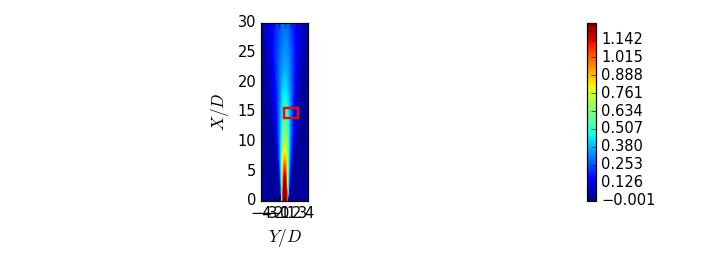

<IPython.core.display.Javascript object>


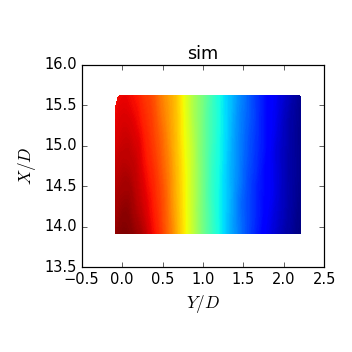

<IPython.core.display.Javascript object>


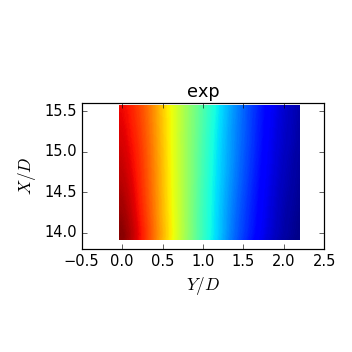

<IPython.core.display.Javascript object>


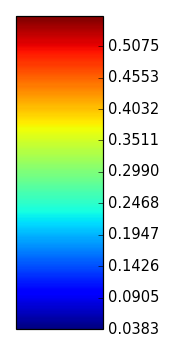

<IPython.core.display.Javascript object>


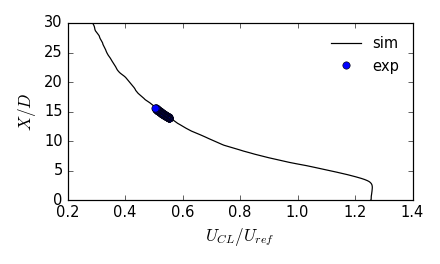

<IPython.core.display.Javascript object>


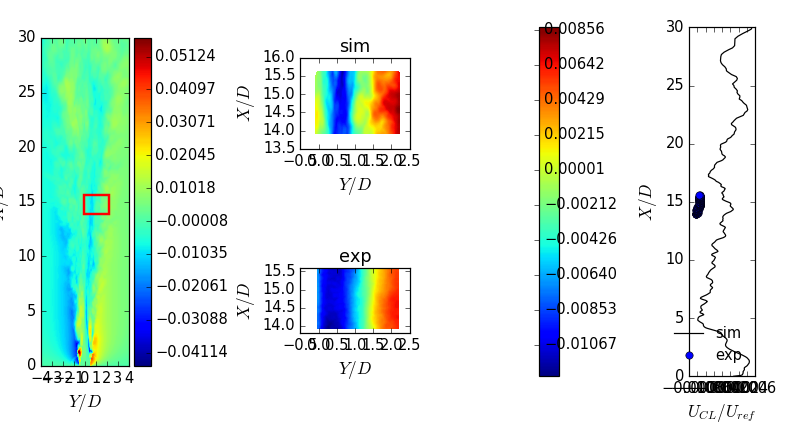

In [19]:
# plot
#plt.style.use('classic')
#plt.style.use('ggplot')
#plt.style.use('seaborn-paper')
#plt.style.use('seaborn-notebook')
plot_data_u(s_avg,e_avg)
plt.savefig('Exp_vs_Sim.png',transparent=True,bbox_inches='tight')
plot_data_v(s_avg,e_avg)